## General information

Two Sigma Financial News Competition is a unique competitions: not only it is a Kernel-only competition, but we aren't supposed to download data and during stage two our solutions will be used to predict future real data.

I'll try to do an extensive EDA for this competition and try to find some interesting things about the data.

P. S. I'l learning to use plotly, so there will be interactive charts at last!

*The work is in progress.*

![](http://fintechnews.ch/wp-content/uploads/2016/11/Deutsche-Bank-Survey-87-of-Financial-Market-Participants-Say-Blockchain-Will-Disrupt-The-Industry-1440x564_c.jpg)

### Getting data and importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import datetime
import lightgbm as lgb
from scipy import stats
from scipy.sparse import hstack, csr_matrix
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud
from collections import Counter
from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
stop = set(stopwords.words('english'))


import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

from xgboost import XGBClassifier
from sklearn import model_selection
from sklearn.metrics import accuracy_score

In [2]:
# official way to get the data
from kaggle.competitions import twosigmanews
env = twosigmanews.make_env()
print('Done!')

Loading the data... This could take a minute.
Done!
Done!


In [3]:
(market_train_df, news_train_df) = env.get_training_data()

We have two datasets, let's explore them separately.

## Market data

We have a really interesting dataset which contains stock prices for many companies over a decade!

For now let's have a look at the data itself and not think about the competition. We can see long-term trends, appearing and declining companies and many other things.

In [4]:
print(f'{market_train_df.shape[0]} samples and {market_train_df.shape[1]} features in the training market dataset.')

4072956 samples and 16 features in the training market dataset.


In [5]:
market_train_df.head()

time   ...    universe
0 2007-02-01 22:00:00+00:00   ...         1.0
1 2007-02-01 22:00:00+00:00   ...         0.0
2 2007-02-01 22:00:00+00:00   ...         1.0
3 2007-02-01 22:00:00+00:00   ...         1.0
4 2007-02-01 22:00:00+00:00   ...         1.0

[5 rows x 16 columns]

At first let's take 10 random assets and plot them.

In [6]:
data = []
for asset in np.random.choice(market_train_df['assetName'].unique(), 10):
    asset_df = market_train_df[(market_train_df['assetName'] == asset)]

    data.append(go.Scatter(
        x = asset_df['time'].dt.strftime(date_format='%Y-%m-%d').values,
        y = asset_df['close'].values,
        name = asset
    ))
layout = go.Layout(dict(title = "Closing prices of 10 random assets",
                  xaxis = dict(title = 'Month'),
                  yaxis = dict(title = 'Price (USD)'),
                  ),legend=dict(
                orientation="h"))
py.iplot(dict(data=data, layout=layout), filename='basic-line')

I plot data for all periods because I'd like to show long-term trends.
Assets are sampled randomly, but you should see that some companies' stocks started trading later, some dissappeared. Disappearence could be due to bankruptcy, acquisition or other reasons.

Well, these were some random companies. But it would be more interesting to see general trends of prices.

In [7]:
data = []
for i in [0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95]:
    price_df = market_train_df.groupby('time')['close'].quantile(i).reset_index()

    data.append(go.Scatter(
        x = price_df['time'].dt.strftime(date_format='%Y-%m-%d').values,
        y = price_df['close'].values,
        name = f'{i} quantile'
    ))
layout = go.Layout(dict(title = "Trends of closing prices by quantiles",
                  xaxis = dict(title = 'Month'),
                  yaxis = dict(title = 'Price (USD)'),
                  ),legend=dict(
                orientation="h"),
    annotations=[
        dict(
            x='2008-09-01 22:00:00+0000',
            y=82,
            xref='x',
            yref='y',
            text='Collapse of Lehman Brothers',
            showarrow=True,
            font=dict(
                family='Courier New, monospace',
                size=16,
                color='#ffffff'
            ),
            align='center',
            arrowhead=2,
            arrowsize=1,
            arrowwidth=2,
            arrowcolor='#636363',
            ax=20,
            ay=-30,
            bordercolor='#c7c7c7',
            borderwidth=2,
            borderpad=4,
            bgcolor='#ff7f0e',
            opacity=0.8
        ),
        dict(
            x='2011-08-01 22:00:00+0000',
            y=85,
            xref='x',
            yref='y',
            text='Black Monday',
            showarrow=True,
            font=dict(
                family='Courier New, monospace',
                size=16,
                color='#ffffff'
            ),
            align='center',
            arrowhead=2,
            arrowsize=1,
            arrowwidth=2,
            arrowcolor='#636363',
            ax=20,
            ay=-30,
            bordercolor='#c7c7c7',
            borderwidth=2,
            borderpad=4,
            bgcolor='#ff7f0e',
            opacity=0.8
        ),
        dict(
            x='2014-10-01 22:00:00+0000',
            y=120,
            xref='x',
            yref='y',
            text='Another crisis',
            showarrow=True,
            font=dict(
                family='Courier New, monospace',
                size=16,
                color='#ffffff'
            ),
            align='center',
            arrowhead=2,
            arrowsize=1,
            arrowwidth=2,
            arrowcolor='#636363',
            ax=-20,
            ay=-30,
            bordercolor='#c7c7c7',
            borderwidth=2,
            borderpad=4,
            bgcolor='#ff7f0e',
            opacity=0.8
        ),
        dict(
            x='2016-01-01 22:00:00+0000',
            y=120,
            xref='x',
            yref='y',
            text='Oil prices crash',
            showarrow=True,
            font=dict(
                family='Courier New, monospace',
                size=16,
                color='#ffffff'
            ),
            align='center',
            arrowhead=2,
            arrowsize=1,
            arrowwidth=2,
            arrowcolor='#636363',
            ax=20,
            ay=-30,
            bordercolor='#c7c7c7',
            borderwidth=2,
            borderpad=4,
            bgcolor='#ff7f0e',
            opacity=0.8
        )
    ])
py.iplot(dict(data=data, layout=layout), filename='basic-line')

It is cool to be able to see how markets fall and rise again.
I have shown 4 events when there were serious stock price drops on the market.
You could also notice that higher quantile prices have increased with time and lower quantile prices decreased.
Maybe the gap between poor and rich increases... on the other hand maybe more "little" companies are ready to go to market and prices of their shares isn't very high.

Now, let's look at these price drops in details.

In [8]:
market_train_df['price_diff'] = market_train_df['close'] - market_train_df['open']
grouped = market_train_df.groupby('time').agg({'price_diff': ['std', 'min']}).reset_index()

In [9]:
print(f"Average standard deviation of price change within a day in {grouped['price_diff']['std'].mean():.4f}.")

Average standard deviation of price change within a day in 1.0335.


In [10]:
g = grouped.sort_values(('price_diff', 'std'), ascending=False)[:10]
g['min_text'] = 'Maximum price drop: ' + (-1 * g['price_diff']['min']).astype(str)
trace = go.Scatter(
    x = g['time'].dt.strftime(date_format='%Y-%m-%d').values,
    y = g['price_diff']['std'].values,
    mode='markers',
    marker=dict(
        size = g['price_diff']['std'].values,
        color = g['price_diff']['std'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = g['min_text'].values
    #text = f"Maximum price drop: {g['price_diff']['min'].values}"
    #g['time'].dt.strftime(date_format='%Y-%m-%d').values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Top 10 months by standard deviation of price change within a day',
    hovermode= 'closest',
    yaxis=dict(
        title= 'price_diff',
        ticklen= 5,
        gridwidth= 2,
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

We can see huge price fluctiations when market crashed. Just think about it... **But this is wrong!** There was no huge crash on January 2010... Let's dive into the data!

### Possible data errors

At first let's simply sort data by the difference between open and close prices.

In [11]:
market_train_df.sort_values('price_diff')[:10]

time assetCode     ...     universe  price_diff
1127598 2010-01-04 22:00:00+00:00      TW.N     ...          0.0  -9948.9900
627547  2008-09-29 22:00:00+00:00      BK.N     ...          1.0  -3261.6136
502997  2008-06-05 22:00:00+00:00     AHG.N     ...          0.0   -982.7000
471381  2008-05-06 22:00:00+00:00    CEPH.O     ...          1.0   -938.9500
242847  2007-09-27 22:00:00+00:00     EXH.N     ...          1.0   -920.0000
3264631 2015-03-16 22:00:00+00:00    TECD.O     ...          0.0   -207.2100
7273    2007-02-08 22:00:00+00:00      BA.N     ...          1.0   -110.4800
375899  2008-02-06 22:00:00+00:00     CME.N     ...          1.0    -98.2400
628075  2008-09-29 22:00:00+00:00     IBM.N     ...          1.0    -77.5200
3565205 2015-11-20 22:00:00+00:00     CMG.N     ...          0.0    -75.8100

[10 rows x 17 columns]

So price of "Towers Watson & Co" shares was almost 10k... I think this is simply an error in data.

But what about Bank of New York Mellon Corp?

Let's see data by Yahoo:

![](https://i.imgur.com/C3COWfe.png)

There were no spikes.

Another case is with cost equal to 999, such numbers are usually suspicious. Let's look at Archrock Inc - no spikes there as well.

![](https://i.imgur.com/KYZKkSd.png)

So, let's try to find strange cases.

In [12]:
market_train_df['close_to_open'] =  np.abs(market_train_df['close'] / market_train_df['open'])

In [13]:
print(f"In {(market_train_df['close_to_open'] >= 1.2).sum()} lines price increased by 20% or more.")
print(f"In {(market_train_df['close_to_open'] <= 0.8).sum()} lines price decreased by 20% or more.")

In 1211 lines price increased by 20% or more.
In 778 lines price decreased by 20% or more.


Well, this isn't much considering we have more than 4 million lines and a lot of these cases are due to price falls during market crash. Well just need to deal with outliers.

In [14]:
print(f"In {(market_train_df['close_to_open'] >= 2).sum()} lines price increased by 100% or more.")
print(f"In {(market_train_df['close_to_open'] <= 0.5).sum()} lines price decreased by 100% or more.")

In 38 lines price increased by 100% or more.
In 16 lines price decreased by 100% or more.


For a quick fix I'll replace outliers in these lines with mean open or close price of this company.

In [15]:
market_train_df['assetName_mean_open'] = market_train_df.groupby('assetName')['open'].transform('mean')
market_train_df['assetName_mean_close'] = market_train_df.groupby('assetName')['close'].transform('mean')

# if open price is too far from mean open price for this company, replace it. Otherwise replace close price.
for i, row in market_train_df.loc[market_train_df['close_to_open'] >= 2].iterrows():
    if np.abs(row['assetName_mean_open'] - row['open']) > np.abs(row['assetName_mean_close'] - row['close']):
        market_train_df.iloc[i,5] = row['assetName_mean_open']
    else:
        market_train_df.iloc[i,4] = row['assetName_mean_close']
        
for i, row in market_train_df.loc[market_train_df['close_to_open'] <= 0.5].iterrows():
    if np.abs(row['assetName_mean_open'] - row['open']) > np.abs(row['assetName_mean_close'] - row['close']):
        market_train_df.iloc[i,5] = row['assetName_mean_open']
    else:
        market_train_df.iloc[i,4] = row['assetName_mean_close']

Now let's try to build that graph again.

In [16]:
market_train_df['price_diff'] = market_train_df['close'] - market_train_df['open']
grouped = market_train_df.groupby(['time']).agg({'price_diff': ['std', 'min']}).reset_index()
g = grouped.sort_values(('price_diff', 'std'), ascending=False)[:10]
g['min_text'] = 'Maximum price drop: ' + (-1 * np.round(g['price_diff']['min'], 2)).astype(str)
trace = go.Scatter(
    x = g['time'].dt.strftime(date_format='%Y-%m-%d').values,
    y = g['price_diff']['std'].values,
    mode='markers',
    marker=dict(
        size = g['price_diff']['std'].values * 5,
        color = g['price_diff']['std'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = g['min_text'].values
    #text = f"Maximum price drop: {g['price_diff']['min'].values}"
    #g['time'].dt.strftime(date_format='%Y-%m-%d').values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Top 10 months by standard deviation of price change within a day',
    hovermode= 'closest',
    yaxis=dict(
        title= 'price_diff',
        ticklen= 5,
        gridwidth= 2,
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

Now the graph is much more reasonable.

Now let's take a look at out target variable.

In [17]:
data = []
for i in [0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95]:
    price_df = market_train_df.groupby('time')['returnsOpenNextMktres10'].quantile(i).reset_index()

    data.append(go.Scatter(
        x = price_df['time'].dt.strftime(date_format='%Y-%m-%d').values,
        y = price_df['returnsOpenNextMktres10'].values,
        name = f'{i} quantile'
    ))
layout = go.Layout(dict(title = "Trends of returnsOpenNextMktres10 by quantiles",
                  xaxis = dict(title = 'Month'),
                  yaxis = dict(title = 'Price (USD)'),
                  ),legend=dict(
                orientation="h"),)
py.iplot(dict(data=data, layout=layout), filename='basic-line')

We can see that quantiles have a high deviation, but mean value doesn't change much.

Now I think it is time to throw an old part of dataset. Let's leave only data since 2010 year, this way we will get rid of the data of the biggest crisis.

Let's look at the target variable now.

In [18]:
data = []
market_train_df = market_train_df.loc[market_train_df['time'] >= '2010-01-01 22:00:00+0000']

price_df = market_train_df.groupby('time')['returnsOpenNextMktres10'].mean().reset_index()

data.append(go.Scatter(
    x = price_df['time'].dt.strftime(date_format='%Y-%m-%d').values,
    y = price_df['returnsOpenNextMktres10'].values,
    name = f'{i} quantile'
))
layout = go.Layout(dict(title = "Treand of returnsOpenNextMktres10 mean",
                  xaxis = dict(title = 'Month'),
                  yaxis = dict(title = 'Price (USD)'),
                  ),legend=dict(
                orientation="h"),)
py.iplot(dict(data=data, layout=layout), filename='basic-line')

Fluctuations seem to be high, but in fact they are lower that 8 percent. In fact it looks like a random noise...

Now let's remember the description:
```
The marketdata contains a variety of returns calculated over different timespans. All of the returns in this set of marketdata have these properties:

    Returns are always calculated either open-to-open (from the opening time of one trading day to the open of another) or close-to-close (from the closing time of one trading day to the open of another).
    Returns are either raw, meaning that the data is not adjusted against any benchmark, or market-residualized (Mktres), meaning that the movement of the market as a whole has been accounted for, leaving only movements inherent to the instrument.
    Returns can be calculated over any arbitrary interval. Provided here are 1 day and 10 day horizons.
    Returns are tagged with 'Prev' if they are backwards looking in time, or 'Next' if forwards looking.
```

Let's have a look at means of these variables.

In [19]:
data = []
for col in ['returnsClosePrevRaw1', 'returnsOpenPrevRaw1',
       'returnsClosePrevMktres1', 'returnsOpenPrevMktres1',
       'returnsClosePrevRaw10', 'returnsOpenPrevRaw10',
       'returnsClosePrevMktres10', 'returnsOpenPrevMktres10',
       'returnsOpenNextMktres10']:
    df = market_train_df.groupby('time')[col].mean().reset_index()
    data.append(go.Scatter(
        x = df['time'].dt.strftime(date_format='%Y-%m-%d').values,
        y = df[col].values,
        name = col
    ))
    
layout = go.Layout(dict(title = "Treand of mean values",
                  xaxis = dict(title = 'Month'),
                  yaxis = dict(title = 'Price (USD)'),
                  ),legend=dict(
                orientation="h"),)
py.iplot(dict(data=data, layout=layout), filename='basic-line')

Well, for me it is difficult to interpret this, but it seems that returns for previous 10 days fluctuate the most.

### News data

In [20]:
news_train_df.head()

time      ...       volumeCounts7D
0 2007-01-01 04:29:32+00:00      ...                    7
1 2007-01-01 07:03:35+00:00      ...                    3
2 2007-01-01 11:29:56+00:00      ...                   17
3 2007-01-01 12:08:37+00:00      ...                   15
4 2007-01-01 12:08:37+00:00      ...                    0

[5 rows x 35 columns]

In [21]:
print(f'{news_train_df.shape[0]} samples and {news_train_df.shape[1]} features in the training news dataset.')

9328750 samples and 35 features in the training news dataset.


The file is too huge to work with text directly, so let's see a wordcloud of the last 100000 headlines.

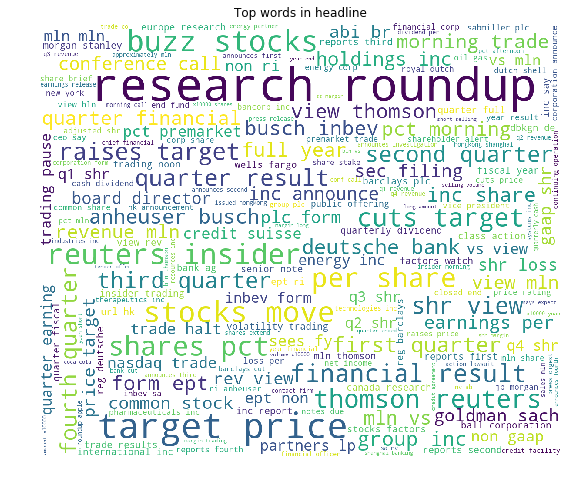

In [22]:
text = ' '.join(news_train_df['headline'].str.lower().values[-1000000:])
wordcloud = WordCloud(max_font_size=None, stopwords=stop, background_color='white',
                      width=1200, height=1000).generate(text)
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud)
plt.title('Top words in headline')
plt.axis("off")
plt.show()

In [23]:
# Let's also limit the time period
news_train_df = news_train_df.loc[news_train_df['time'] >= '2010-01-01 22:00:00+0000']

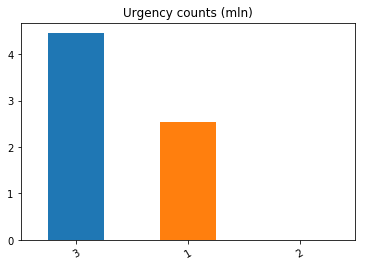

In [24]:
(news_train_df['urgency'].value_counts() / 1000000).plot('bar');
plt.xticks(rotation=30);
plt.title('Urgency counts (mln)');

Well, it seems that in fact urgency "2" is almost never used.

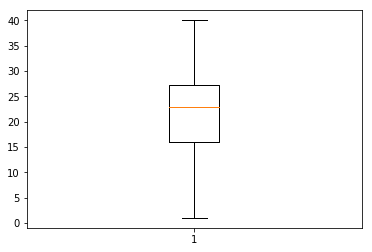

In [25]:
news_train_df['sentence_word_count'] =  news_train_df['wordCount'] / news_train_df['sentenceCount']
plt.boxplot(news_train_df['sentence_word_count'][news_train_df['sentence_word_count'] < 40]);

There are some big outliers, but sentences mostly have 15-25 words in them.

In [26]:
news_train_df['provider'].value_counts().head(10)

RTRS    5517618
PRN      503267
BSW      472612
GNW      145309
MKW      129621
LSE       64250
HIIS      56489
RNS       39833
CNW       30779
ONE       25233
Name: provider, dtype: int64

It isn't surprising that Reuters is the most common provider :)

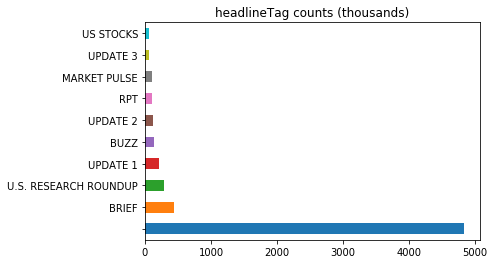

In [27]:
(news_train_df['headlineTag'].value_counts() / 1000)[:10].plot('barh');
plt.title('headlineTag counts (thousands)');

Well, most news are tagless.

In [28]:
for i, j in zip([-1, 0, 1], ['negative', 'neutral', 'positive']):
    df_sentiment = news_train_df.loc[news_train_df['sentimentClass'] == i, 'assetName']
    print(f'Top mentioned companies for {j} sentiment are:')
    print(df_sentiment.value_counts().head(5))
    print('')

Top mentioned companies for negative sentiment are:
Apple Inc                  22518
JPMorgan Chase & Co        20647
BP PLC                     19328
Goldman Sachs Group Inc    17955
Bank of America Corp       17704
Name: assetName, dtype: int64

Top mentioned companies for neutral sentiment are:
HSBC Holdings PLC    19462
Credit Suisse AG     14632
Deutsche Bank AG     12959
Barclays PLC         12414
Apple Inc            10994
Name: assetName, dtype: int64

Top mentioned companies for positive sentiment are:
Apple Inc                19020
Barclays PLC             18051
Royal Dutch Shell PLC    15484
General Electric Co      14163
Boeing Co                14080
Name: assetName, dtype: int64



I think it is quite funny that Apple is a company with most both negative and positive sentiments.

At first I was sad that we don't have access to the texts of the news, but I have realized that we won't be able to use them anyway due to kernel memory limitations.

## Modelling

It's time to build a model!
I think that in this case we should build a binary classifier - we will simply predict whether the target goes up or down.

In [29]:
#%%time
# code mostly takes from this kernel: https://www.kaggle.com/ashishpatel26/bird-eye-view-of-two-sigma-xgb

def data_prep(market_df,news_df):
    market_df['time'] = market_df.time.dt.date
    market_df['returnsOpenPrevRaw1_to_volume'] = market_df['returnsOpenPrevRaw1'] / market_df['volume']
    market_df['close_to_open'] = market_df['close'] / market_df['open']
    market_df['volume_to_mean'] = market_df['volume'] / market_df['volume'].mean()
    
    news_df['time'] = news_df.time.dt.hour
    news_df['sourceTimestamp']= news_df.sourceTimestamp.dt.hour
    news_df['firstCreated'] = news_df.firstCreated.dt.date
    news_df['assetCodesLen'] = news_df['assetCodes'].map(lambda x: len(eval(x)))
    news_df['assetCodes'] = news_df['assetCodes'].map(lambda x: list(eval(x))[0])
    news_df['headlineLen'] = news_df['headline'].apply(lambda x: len(x))
    news_df['assetCodesLen'] = news_df['assetCodes'].apply(lambda x: len(x))
    news_df['asset_sentiment_count'] = news_df.groupby(['assetName', 'sentimentClass'])['time'].transform('count')
    news_df['asset_sentence_mean'] = news_df.groupby(['assetName', 'sentenceCount'])['time'].transform('mean')
    lbl = {k: v for v, k in enumerate(news_df['headlineTag'].unique())}
    news_df['headlineTagT'] = news_df['headlineTag'].map(lbl)
    kcol = ['firstCreated', 'assetCodes']
    news_df = news_df.groupby(kcol, as_index=False).mean()

    market_df = pd.merge(market_df, news_df, how='left', left_on=['time', 'assetCode'], 
                            right_on=['firstCreated', 'assetCodes'])

    lbl = {k: v for v, k in enumerate(market_df['assetCode'].unique())}
    market_df['assetCodeT'] = market_df['assetCode'].map(lbl)
    
    market_df = market_df.dropna(axis=0)
    
    return market_df

market_train_df.drop(['price_diff', 'assetName_mean_open', 'assetName_mean_close'], axis=1, inplace=True)
market_train = data_prep(market_train_df, news_train_df)
print(market_train.shape)
up = market_train.returnsOpenNextMktres10 >= 0

fcol = [c for c in market_train_df.columns if c not in ['assetCode', 'assetCodes', 'assetCodesLen', 'assetName', 'assetCodeT', 'volume_to_mean',
                                             'firstCreated', 'headline', 'headlineTag', 'marketCommentary', 'provider', 'returnsOpenPrevRaw1_to_volume',
                                             'returnsOpenNextMktres10', 'sourceId', 'subjects', 'time', 'time_x', 'universe','sourceTimestamp']]

X = market_train[fcol].values
up = up.values
r = market_train.returnsOpenNextMktres10.values

# Scaling of X values
mins = np.min(X, axis=0)
maxs = np.max(X, axis=0)
rng = maxs - mins
X = 1 - ((maxs - X) / rng)

(620459, 54)


In [30]:
X_train, X_test, up_train, up_test, r_train, r_test = model_selection.train_test_split(X, up, r, test_size=0.1, random_state=99)

xgb_up = XGBClassifier(n_jobs=4,
                       n_estimators=300,
                       max_depth=3,
                       eta=0.15)

In [31]:
%%time
xgb_up.fit(X_train,up_train)
print("Accuracy Score: ",accuracy_score(xgb_up.predict(X_test),up_test))

Accuracy Score:  0.553927731038262
CPU times: user 5min 7s, sys: 152 ms, total: 5min 7s
Wall time: 1min 17s


/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



In [32]:
def generate_color():
    color = '#{:02x}{:02x}{:02x}'.format(*map(lambda x: np.random.randint(0, 255), range(3)))
    return color

df = pd.DataFrame({'imp': xgb_up.feature_importances_, 'col':fcol})
df = df.sort_values(['imp','col'], ascending=[True, False])
data = [df]
for dd in data:  
    colors = []
    for i in range(len(dd)):
         colors.append(generate_color())

    data = [
        go.Bar(
        orientation = 'h',
        x=dd.imp,
        y=dd.col,
        name='Features',
        textfont=dict(size=20),
            marker=dict(
            color= colors,
            line=dict(
                color='#000000',
                width=0.5
            ),
            opacity = 0.87
        )
    )
    ]
    layout= go.Layout(
        title= 'Feature Importance of XGBOOST',
        xaxis= dict(title='Columns', ticklen=5, zeroline=False, gridwidth=2),
        yaxis=dict(title='Value Count', ticklen=5, gridwidth=2),
        showlegend=True
    )

    py.iplot(dict(data=data,layout=layout), filename='horizontal-bar')

In [33]:
days = env.get_prediction_days()
import time

n_days = 0
prep_time = 0
prediction_time = 0
packaging_time = 0
for (market_obs_df, news_obs_df, predictions_template_df) in days:
    n_days +=1
    if n_days % 50 == 0:
        print(n_days,end=' ')
    
    t = time.time()
    market_obs_df = data_prep(market_obs_df, news_obs_df)
    market_obs_df = market_obs_df[market_obs_df.assetCode.isin(predictions_template_df.assetCode)]
    X_live = market_obs_df[fcol].values
    X_live = 1 - ((maxs - X_live) / rng)
    prep_time += time.time() - t
    
    t = time.time()
    lp = xgb_up.predict_proba(X_live)
    prediction_time += time.time() -t
    
    t = time.time()
    confidence = 2* lp[:,1] -1
    preds = pd.DataFrame({'assetCode':market_obs_df['assetCode'],'confidence':confidence})
    predictions_template_df = predictions_template_df.merge(preds,how='left').drop('confidenceValue',axis=1).fillna(0).rename(columns={'confidence':'confidenceValue'})
    env.predict(predictions_template_df)
    packaging_time += time.time() - t
    
env.write_submission_file()

50 100 150 200 250 300 350 400 450 500 550 600 Your submission file has been saved. Once you `Commit` your Kernel and it finishes running, you can submit the file to the competition from the Kernel Viewer `Output` tab.
